## Problem Set 6 (February 26, 2017)
## MACS 30100
## Dr. Rick Evans
## Kevin Sun

### 1) Decision Trees

In [2]:
# import relevant libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

/Users/kevinsun/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# import data
biden_GOAT_vp = pd.read_csv('biden.csv')
biden_GOAT_vp.head()

biden  female  age  educ  dem  rep
0     90       0   19    12    1    0
1     70       1   51    14    1    0
2     60       0   27    14    0    0
3     50       1   43    14    1    0
4     60       1   38    14    0    1

### 1a)

In [4]:
# set response and predictor variables
y = biden_GOAT_vp['biden'].values
X = biden_GOAT_vp[['female', 'age', 'educ', 'dem', 'rep']].values

In [5]:
# split the data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=25)
biden_2020_tree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=3)
biden_2020_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

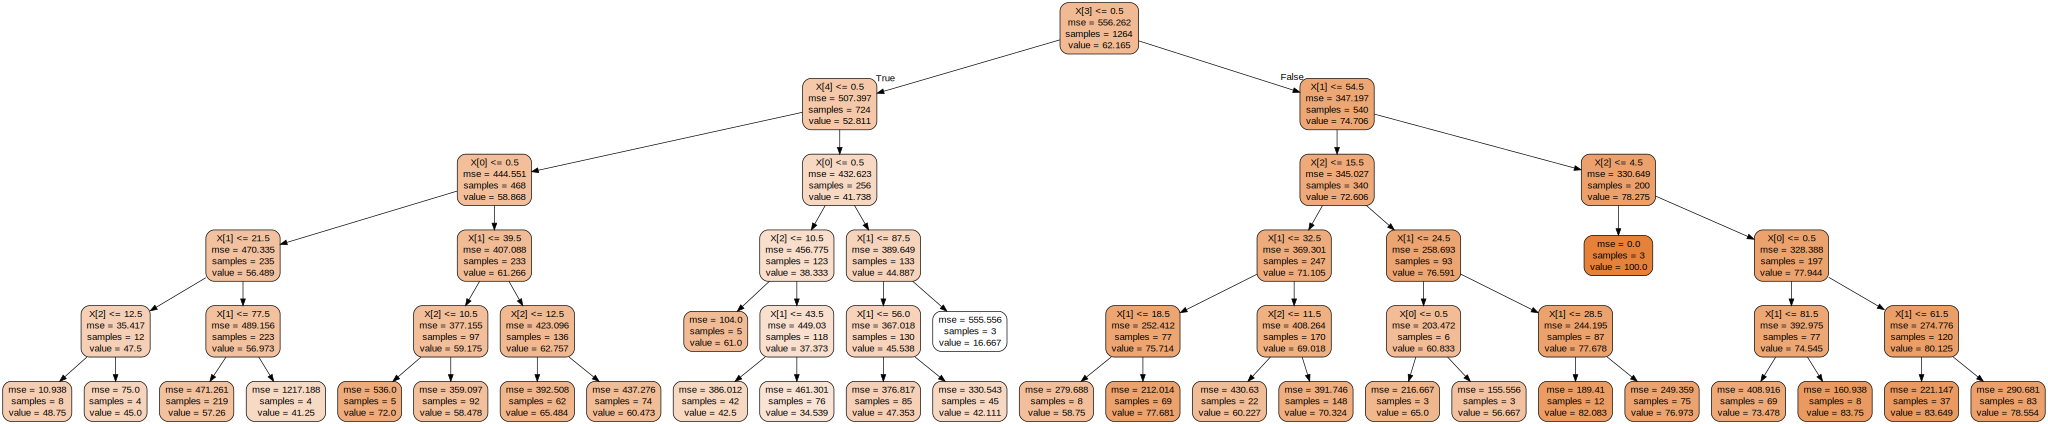

In [6]:
# map the tree visualization
biden_2020_tree_viz = export_graphviz(biden_2020_tree, out_file=None, rounded=True, filled=True)
graph = graphviz.Source(biden_2020_tree_viz)
graph.render('biden_2020_tree')
graph

In [7]:
y_pred = biden_2020_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 406.672049146


#### Interpretation

X[0] = female, X[1] = age, X[2] = educ, X[3]= dem, X[4] = rep

The main split is on our X3 variable (dem - whether or not individual identifies as a Democrat). As we would expect, individuals who do identify as Democrats have much warmer feelings towards Joe Biden (~74) compared to non-Democrat individuals' feelings (~52). 

Within identfied Democrats, the tree further divides on our X1 variable with those below 54.5 years of age and those above. Those above 54.5 years of age have slightly warmer feelings than those below (78.275 vs. 72.606). Within each of these age groups, we further divide by on our X2 variable (educ - num. of years of education). For younger individuals below 54.5 years-old, if they have greater than 15.5 years of education, they have slightly warmer feelings towards Biden than those will less education. We can continue interpreting this all the way down the tree; for example, for individuals who identify as Democratic, who are over 54 years-old, have more than 4.5 years of education, male, and also over 81 years-old, have the highest approval rating of Joe Biden at 83.75.

Within non-Democrat individuals, the tree first divides on our X4 variable (rep - whether the individual identifies as Republican or not). Republican-identified individuals have much colder feelings towards Biden at 41.738 compared to Independent or third party identified individuals at 58.868. Within Republican identified individuals, women view Biden more favorably than men. Within non-Republican and non-Democrat individuals women also have slightly more favorable views of Biden than men. 

### 1b) Pruning the tree

In [8]:
# k fold for each level max_depth
for depth in range(1,15):
    biden_2024_tree = DecisionTreeRegressor(max_depth=depth)
    biden_2024_tree.fit(X_train, y_train)
    y_pred2 = biden_2024_tree.predict(X_test)
    MSE2 = mean_squared_error(y_test, y_pred2)
    print('with max_depth {}, MSE ={}'.format(depth, MSE2))

with max_depth 1, MSE =420.0224529349668
with max_depth 2, MSE =400.06539818418173
with max_depth 3, MSE =394.7619999223366
with max_depth 4, MSE =400.1132903570054
with max_depth 5, MSE =408.10563570194836
with max_depth 6, MSE =426.0465707974785
with max_depth 7, MSE =459.27643490261846
with max_depth 8, MSE =529.0006045064928
with max_depth 9, MSE =549.3218684398247
with max_depth 10, MSE =566.7645974898735
with max_depth 11, MSE =607.6881127247891
with max_depth 12, MSE =643.6832150313385
with max_depth 13, MSE =649.6188403346417
with max_depth 14, MSE =673.6207825154811


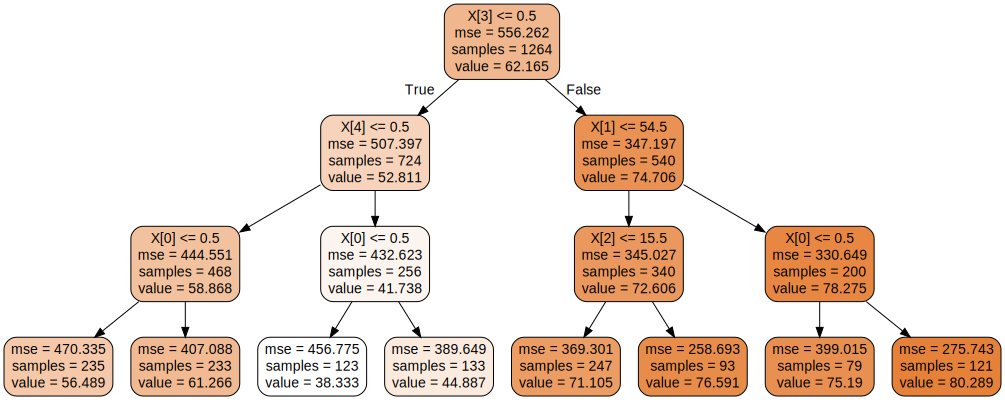

In [9]:
biden_2024_tree = DecisionTreeRegressor(min_samples_leaf=5, max_depth=3)
biden_2024_tree.fit(X_train, y_train)
# map the tree visualization
biden_2024_tree_viz = export_graphviz(biden_2024_tree, out_file=None, rounded=True, filled=True)
graph = graphviz.Source(biden_2024_tree_viz)
graph.render('biden_2024_tree')
graph

In [10]:
y_pred = biden_2024_tree.predict(X_test)
MSE1b = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1b)

MSE= 396.193714632


X[0] = female, X[1] = age, X[2] = educ, X[3]= dem, X[4] = rep

We observe that using a max_depth=3 results in the lowest MSE level and improves our ability the see the main splits in opinion towards Joe Biden from the data. It is still readily apparent that Democrat-identified voters have much warmer feelings towards Biden than non-Democratic voters. Moreover, we can tell that across all parties, women hold more positive sentiment towards Biden than men. These general themes are clearer to the viewer under the pruned tree.

### 1c) Bagging

In [11]:
biden_bags_presidency_tree = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=15)
biden_bags_presidency_tree.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=15, verbose=0, warm_start=False)

In [12]:
# calculate MSE
biden_bags_presidency_tree.score(X, y)
y_pred_bag = biden_bags_presidency_tree.oob_prediction_
MSE2 = mean_squared_error(y, y_pred_bag)
print('MSE=', MSE2)

MSE= 406.000558395


In [13]:
importances = np.mean([
    tree.feature_importances_ for tree in biden_bags_presidency_tree.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

print("Feature ranking:")
features = ['female', 'age', 'dem', 'rep', 'educ']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[indices[f]], ": ",str(importances[indices[f]]))

Feature ranking:
1 .  age :  0.442912703961
2 .  dem :  0.200576259716
3 .  rep :  0.190323544392
4 .  educ :  0.106028225513
5 .  female :  0.060159266419


Of all the variables, the *age* variable does the best at explaining variance in the dataset. 

### 1d) Random Forest

In [15]:
B = 100
m = 1
biden_random_forest = RandomForestRegressor(n_estimators=B, max_features=m, bootstrap=True,
                                  oob_score=True, random_state=15)
biden_random_forest.fit(X, y)

biden_random_forest.score(X, y)
y_pred_rf = biden_random_forest.oob_prediction_
MSE4 = mean_squared_error(y, y_pred_rf)
print('MSE=', MSE4)

MSE= 530.846244653


In [16]:
# calculate variable importances
importances = biden_random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# print the rankings of features
print("Feature Ranking:")
print()
features = ['female', 'age', 'educ', 'dem', 'rep']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[indices[f]], ": ",str(importances[indices[f]]))

Feature Ranking:

1 .  age :  0.512488272091
2 .  dem :  0.186067270405
3 .  educ :  0.149132921787
4 .  rep :  0.130145660881
5 .  female :  0.0221658748364


In [17]:
B = 100
m = 2
biden_random_forest = RandomForestRegressor(n_estimators=B, max_features=m, bootstrap=True,
                                  oob_score=True, random_state=15)
biden_random_forest.fit(X, y)

biden_random_forest.score(X, y)
y_pred_rf = biden_random_forest.oob_prediction_
MSE4 = mean_squared_error(y, y_pred_rf)
print('MSE=', MSE4)

# calculate variable importances
importances = biden_random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# print the rankings of features
print("Feature Ranking:")
print()
features = ['female', 'age', 'educ', 'dem', 'rep']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[indices[f]], ": ",str(importances[indices[f]]))

MSE= 535.734919575
Feature Ranking:

1 .  age :  0.509860910286
2 .  dem :  0.188200497016
3 .  educ :  0.150197826278
4 .  rep :  0.129923130084
5 .  female :  0.0218176363351


In [18]:
B = 100
m = 3
biden_random_forest = RandomForestRegressor(n_estimators=B, max_features=m, bootstrap=True,
                                  oob_score=True, random_state=15)
biden_random_forest.fit(X, y)

biden_random_forest.score(X, y)
y_pred_rf = biden_random_forest.oob_prediction_
MSE4 = mean_squared_error(y, y_pred_rf)
print('MSE=', MSE4)

# calculate variable importances
importances = biden_random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# print the rankings of features
print("Feature Ranking:")
print()
features = ['female', 'age', 'educ', 'dem', 'rep']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[indices[f]], ": ",str(importances[indices[f]]))

MSE= 529.067842604
Feature Ranking:

1 .  age :  0.486410244184
2 .  dem :  0.201272984114
3 .  educ :  0.162942100787
4 .  rep :  0.120179231616
5 .  female :  0.0291954392984


### Interpretation

When B=3, we have the lowest MSE value. We would expect more accurate estimates when including more variables in the model. That being said, the *female* variables appears to remain the most important variable for this model and has the higest explanatory power with *democrat* and *republican* being relatively lower in informing us about sentiment towards Biden. 